<font size=6><b>Lec02 : 금융을 위한 Pandas 활용 </b></font>

### 주식 용어
- 우리나라는 주식 1980년대부터 
- 코넥스 : 상장을 앞두고 있는 비상장주 -> 시장 외 거래, 예금자보호 받지 못함(위험)
<pre>
* <b>시가총액</b> : 시가총액은 기업의 가치를 결정하는 지표   --> 매일 달라짐(매일 주식가격 변동)
          시가총액 = 주식 수 × 주식 1주당 가격

* <B>KOSPI</B> : 한국증권거래소에 상장되어 거래되는 모든 주식의 시가총액을 합쳐서 <b>주식시장 전체 장세의 흐름</b>을 나타내는 지수        
          KOSPI 지수 = (현재 시가총액 합 / 1980. 1. 4 기준 시가총액 합) × 100<br>
          KOSPI 50 / KOSPI 100 / KOSPI 200   (sorting 했을 때 몇개까지 끊을 것인지)
 
* <B> KOSDAQ</B> : <b>중소기업이나 신생 벤처기업</b>을 위한 1996년 첨단 기술주 중심인 미국의 나스닥(NASDAQ) 시장을 본떠 만든 대한민국의 주식시장   --> 1990년대 이후 정보만 가져 올 수 있음

* <B> KOSPI 200</B> : 어업, 광업, 제조업, 전기가스업, 건설업, 서비스업, 통신업 등 8개의 산업군에서 각 산업을 대표할 수 있는 200개의 종목을 뽑아서 만든 지수

* <B> KODEX 200</B> : 삼성자산운용에서 운용하는 ETF로, KOSPI 200을 추종(복제)하는 ETF<br>
          추종 : 코스피 200오름 -> 나도 오름

* <B> ETF</B> : 특정 주가지수 또는 금, 채권, 원유와 같은 특정 자산가격를 그대로 추종하는 성격을 지닌 금융상품
 </pre>


In [1]:
from pykrx import stock
from pykrx import bond
import FinanceDataReader as fdr

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)



# Data Load by pykrx

In [2]:
tickers = stock.get_market_ticker_list("20220225", market="KOSDAQ") #KOSPI, KOSDAQ, KONEX         # 해당 일자 코스피 상장된 ticker
print(tickers[:5])

['060310', '054620', '265520', '211270', '032790']


In [3]:
종목명 = stock.get_market_ticker_name('035760')
print(종목명)

CJ ENM


In [4]:
df = stock.get_market_ohlcv("2021-01-01", "2021-12-31", "005930")
df.head(3)

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,3185356823460,2.47
2021-01-05,81600,83900,81600,83900,35335669,2915618322800,1.08
2021-01-06,83300,84500,82100,82200,42089013,3506903681680,-2.03


In [5]:
df.columns

Index(['시가', '고가', '저가', '종가', '거래량', '거래대금', '등락률'], dtype='object')

* 컬럼 이름 변경

In [6]:
df = df[['시가', '고가', '저가', '종가', '거래량']].copy()
df.columns = ['open','high','low','close','volumn']  # 한글 사용하지 말기

In [7]:
df.isna().sum()

open      0
high      0
low       0
close     0
volumn    0
dtype: int64

# 금융을 위한 pandas

## shift(N)
* N일가격 컬럼에 가져오기
* diff를 계산하기 위해 하나씩 값을 끌어내림
* <font size=4 color=red><b>전일 대비 가격 증감에 주로 사용 

In [8]:
df['close_shift'] = df['close'].shift(1) # 전일 종가, 아래로 끌어내림
df.head()

,open,high,low,close,volumn,close_shift
날짜,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,NaN
2021-01-05,81600,83900,81600,83900,35335669,83000.0
2021-01-06,83300,84500,82100,82200,42089013,83900.0
2021-01-07,82800,84200,82700,82900,32644642,82200.0
2021-01-08,83300,90000,83000,88800,59013307,82900.0


In [9]:
df['close'].shift(-1)  # 말일 기준, 위로 끌어올림

날짜
2021-01-04    83900.0
2021-01-05    82200.0
2021-01-06    82900.0
2021-01-07    88800.0
2021-01-08    91000.0
               ...   
2021-12-24    80200.0
2021-12-27    80300.0
2021-12-28    78800.0
2021-12-29    78300.0
2021-12-30        NaN
Name: close, Length: 248, dtype: float64

## df["Close"] - df["Close"].shift(1)

In [10]:
last_day = df["close"].shift(1)
today    = df["close"]
df["pct_chg1"] =   ( (today - last_day) / last_day ) * 100   # (오늘 종가 - 어제 종가) / 어제 종가 =전일 대비 증감률
df.head(3)

,open,high,low,close,volumn,close_shift,pct_chg1
날짜,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,NaN,NaN
2021-01-05,81600,83900,81600,83900,35335669,83000.0,1.084337
2021-01-06,83300,84500,82100,82200,42089013,83900.0,-2.026222


## diff(N)
* 변화량 : 현재가격 - N일가격 
* <font size=4 color=red><b> N일 대비 가격 증감에 주로 사용
* <font size=4 color=blue><b> df['close'].diff(1) = </font>  <font size=4 color=red><b> df['close'] - df['colse'].shift(1)

In [11]:
df['close_diff'] = df['close'].diff(1)
df['close-close_shift'] = df['close'] - df['close_shift']
df.head()

,open,high,low,close,volumn,close_shift,pct_chg1,close_diff,close-close_shift
날짜,,,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,NaN,NaN,NaN,NaN
2021-01-05,81600,83900,81600,83900,35335669,83000.0,1.084337,900.0,900.0
2021-01-06,83300,84500,82100,82200,42089013,83900.0,-2.026222,-1700.0,-1700.0
2021-01-07,82800,84200,82700,82900,32644642,82200.0,0.851582,700.0,700.0
2021-01-08,83300,90000,83000,88800,59013307,82900.0,7.117008,5900.0,5900.0


## pct_change(N)
* 백분위 변화율 : 현재가격 - N일가격 
    * (현재가격-N일전가격)/N일전가격 == diff/N일전 가격
* <font size=4 color=red><b>전일 대비 수익률에 주로 사용

In [12]:
df['pct_chg'] = df['close'].pct_change()
df.head()

,open,high,low,close,volumn,close_shift,pct_chg1,close_diff,close-close_shift,pct_chg
날짜,,,,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,NaN,NaN,NaN,NaN,NaN
2021-01-05,81600,83900,81600,83900,35335669,83000.0,1.084337,900.0,900.0,0.010843
2021-01-06,83300,84500,82100,82200,42089013,83900.0,-2.026222,-1700.0,-1700.0,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,82200.0,0.851582,700.0,700.0,0.008516
2021-01-08,83300,90000,83000,88800,59013307,82900.0,7.117008,5900.0,5900.0,0.071170


## rolling(window=N)
*  N일 간격으로 그룹화해 가격을 집계
* <font size=4 color=red><b> 이동평균선에 주로 사용

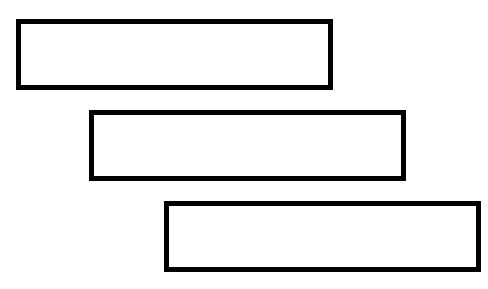

In [13]:
df['close'].rolling(window=5).mean() # 현재날짜 기준으로 5일전 까지의 종가 평균

날짜
2021-01-04        NaN
2021-01-05        NaN
2021-01-06        NaN
2021-01-07        NaN
2021-01-08    84160.0
               ...   
2021-12-24    79000.0
2021-12-27    79620.0
2021-12-28    80060.0
2021-12-29    79940.0
2021-12-30    79620.0
Name: close, Length: 248, dtype: float64

In [14]:
df['close_ma5']   = df['close'].rolling(window=5).mean() # 단기
df['close_ma20']  = df['close'].rolling(window=20).mean() 
df['close_ma60']  = df['close'].rolling(window=60).mean()  
df['close_ma120'] = df['close'].rolling(window=120).mean() # 중장기
df.head(7)

,open,high,low,close,volumn,close_shift,pct_chg1,close_diff,close-close_shift,pct_chg,close_ma5,close_ma20,close_ma60,close_ma120
날짜,,,,,,,,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,81600,83900,81600,83900,35335669,83000.0,1.084337,900.0,900.0,0.010843,NaN,NaN,NaN,NaN
2021-01-06,83300,84500,82100,82200,42089013,83900.0,-2.026222,-1700.0,-1700.0,-0.020262,NaN,NaN,NaN,NaN
2021-01-07,82800,84200,82700,82900,32644642,82200.0,0.851582,700.0,700.0,0.008516,NaN,NaN,NaN,NaN
2021-01-08,83300,90000,83000,88800,59013307,82900.0,7.117008,5900.0,5900.0,0.071170,84160.0,NaN,NaN,NaN
2021-01-11,90000,96800,89500,91000,90306177,88800.0,2.477477,2200.0,2200.0,0.024775,85760.0,NaN,NaN,NaN
2021-01-12,90300,91400,87800,90600,48682416,91000.0,-0.439560,-400.0,-400.0,-0.004396,87100.0,NaN,NaN,NaN


## resample()
* 날짜 끊어오기
* <font color="red"><b>인덱스가 반드시 날짜인 경우만 사용 가능
* 업샘플링 : 보간법 사용해 샘플수 늘리기
* 다운샘플링 : 집계 사용해 샘플수 줄이기

In [15]:
print(df.shape)
df['close'].resample(rule='M').mean()  #월평균(월말)
# 인덱스가 반드시 날짜인 경우만 사용 가능

(248, 14)


날짜
2021-01-31    86565.000000
2021-02-28    83127.777778
2021-03-31    82072.727273
2021-04-30    83586.363636
2021-05-31    80521.052632
2021-06-30    81104.545455
2021-07-31    79577.272727
2021-08-31    77023.809524
2021-09-30    76305.263158
2021-10-31    70563.157895
2021-11-30    71536.363636
2021-12-31    77809.090909
Freq: M, Name: close, dtype: float64

In [16]:
print(df.shape)
print( df['close'].resample(rule='MS').first() )  #매월 초 가격
# print( df['close'].resample(rule='M').last() )    #매월 말 가격

(248, 14)
날짜
2021-01-01    83000
2021-02-01    83000
2021-03-01    83600
2021-04-01    82900
2021-05-01    81700
2021-06-01    80600
2021-07-01    80100
2021-08-01    79300
2021-09-01    76800
2021-10-01    73200
2021-11-01    69900
2021-12-01    74400
Freq: MS, Name: close, dtype: int32


# [실습] FinanceDataReader

* 시가총액 : 시가총액은 기업의 가치를 결정하는 지표
          시가총액 = 주식 수 × 주식 1주당 가격

* KOSPI : 한국증권거래소에 상장되어 거래되는 모든 주식의 시가총액을 합쳐서 주식시장 전체 장세의 흐름을 나타내는 지수
          KOSPI 지수 = (현재 시가총액 합 / 1980. 1. 4 기준 시가총액 합) × 100
 
*  KOSDAQ : 중소기업이나 신생 벤처기업을 위한 1996년 첨단 기술주 중심인 미국의 나스닥(NASDAQ) 시장을 본떠 만든 대한민국의 주식시장

*  KOSPI 200 : 어업, 광업, 제조업, 전기가스업, 건설업, 서비스업, 통신업 등 8개의 산업군에서 각 산업을 대표할 수 있는 200개의 종목을 뽑아서 만든 지수

*  KODEX 200 : 삼성자산운용에서 운용하는 ETF로, KOSPI 200을 추종(복제)하는 ETF

*  ETF : 특정 주가지수 또는 금, 채권, 원유와 같은 특정 자산가격를 그대로 추종하는 성격을 지닌 금융상품

## Data Load

### FinanceDataReader 사용 시 

In [17]:
import FinanceDataReader as fdr
df_ss = fdr.DataReader('005930', '2021-01-01', '2021-12-31', exchange='KRX') 
df_ss.head(3)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262


* 현재 investing 에러..
* 2023/4/26 현재 정상 구동

In [18]:
# ! pip install -U finance-datareader 

In [19]:
# df_aapl = fdr.DataReader('AMZN', '2021-01-01', '2021-12-31')
df_aapl = fdr.DataReader('AAPL', '2021-01-01', '2021-12-31')

In [20]:
# Image(filename='./img/lec05_2.png', width = 600)

In [21]:
# Image(filename='./img/lec05_1.png', width = 600)

### pandas_datareader 사용 시

In [22]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

* 상장 회사 정보 가져오기

In [23]:
ticker_df = fdr.StockListing('KRX')  # 'KRX', 'KOSPI', 'KODAQ', 'KONEX'
ticker_df.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,63900,2,-200,-0.31,64100,64400,63300,5162537,329506598600,381469104945000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,580000,1,13000,2.29,573000,585000,567000,177662,102746251000,135720000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,87600,1,200,0.23,87900,88200,86000,911290,79505053400,63773007174000,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,772000,2,-11000,-1.40,780000,782000,767000,31098,24041195000,54946328000000,71174000,STK
4,051910,KR7051910008,LG화학,KOSPI,,738000,1,11000,1.51,734000,740000,726000,96298,70712503000,52097149134000,70592343,STK


In [24]:
ticker_df['Market'].value_counts()

KOSDAQ           1585
KOSPI             948
KONEX             129
KOSDAQ GLOBAL      51
Name: Market, dtype: int64

In [25]:
ticker_df = fdr.StockListing('NASDAQ')  # 'NASDAQ', 'NYSE', 'AMEX' and 'S&P500', 'SSE'(상해), 'SZSE'(심천), 'HKEX'(홍콩), 'TSE'(도쿄)
print(ticker_df.shape)
ticker_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4323/4323 [00:07<00:00, 543.60it/s]

(4323, 4)


,Symbol,Name,Industry,IndustryCode
0,AAPL,Apple Inc,"컴퓨터, 전화 및 가전제품",571060
1,MSFT,Microsoft Corp,소프트웨어 및 IT서비스,572010
2,AMZN,Amazon.com Inc,다양한 소매업,534020
3,GOOGL,Alphabet Inc Class A,소프트웨어 및 IT서비스,572010
4,NVDA,NVIDIA Corp,반도체 및 반도체 장비,571010


In [26]:
# df_ss = pdr.DataReader("005930.KS" ,start='2018-01-01' ,end='2019-12-31' ,data_source='yahoo' )
df_ss = pdr.get_data_yahoo('005930.KS', '2021-01-01', '2021-12-31')   # Adj Close(수정종가)까지 가져옴
print(df_ss.shape)
df_ss.head(3)

[*********************100%***********************]  1 of 1 completed
(248, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,79551.828125,38655276
2021-01-05,81600.0,83900.0,81600.0,83900.0,80414.445312,35335669
2021-01-06,83300.0,84500.0,82100.0,82200.0,78785.078125,42089013


In [27]:
df_ts = pdr.get_data_yahoo('TSLA', '2021-01-01', '2021-12-31')
print(df_ts.shape)
df_ts.head(3)

[*********************100%***********************]  1 of 1 completed
(251, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000


### yfinance (pandas_datareader) 사용 시

In [28]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [29]:
df_ts = yf.download("TSLA", start="2021-01-01", end="2021-12-31")
df_ts.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000
2021-01-07,259.209991,272.329987,258.399994,272.013336,272.013336,154496700
2021-01-08,285.333344,294.829987,279.463318,293.339996,293.339996,225166500


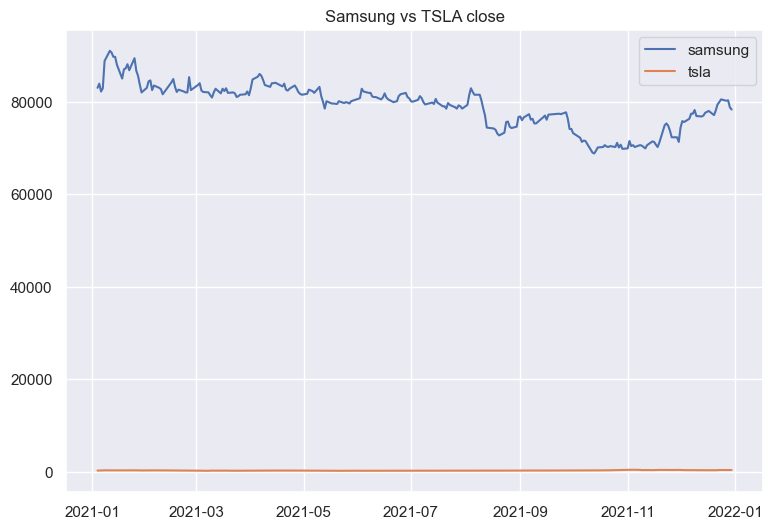

In [30]:
plt.figure(figsize=(9, 6))
plt.title('Samsung vs TSLA close')
plt.plot(df_ss.index, df_ss['Close'], label='samsung')
plt.plot(df_ts.index, df_ts['Close'], label='tsla')
plt.legend()
plt.show() # 달러와 원 비교이기 때문에 차트 이렇게 나옴   --> 반드시 지수화!!! : 비율화(기준날짜 기준으로 해당날짜의 가격이 얼마인가)

## 일간변동률(Daily Percent Change) 
* <font color=red size=4><b>가격이 다른 두 주가의 수익률 비교
* <font color=red>오늘 - 기준일 / 기준일 * 100
* ref : https://www.investopedia.com/terms/p/percentage-change.asp

<pre>
* increase   = New Number - Original Number
* increase%  = Increase ÷ Original Number × 100.
* decrease   = Original Number - New Number
* decrease%  = Decrease ÷ Original Number × 100

  

### df["Close"].pct_change() 

In [31]:
df_ss["pct_chg2"] = df_ss["Close"].pct_change()  # 전일 대비 등락율
df_ts["pct_chg2"] = df_ts["Close"].pct_change() 
df_ss.head(3)

,Open,High,Low,Close,Adj Close,Volume,pct_chg2
Date,,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,79551.828125,38655276,NaN
2021-01-05,81600.0,83900.0,81600.0,83900.0,80414.445312,35335669,0.010843
2021-01-06,83300.0,84500.0,82100.0,82200.0,78785.078125,42089013,-0.020262


### 결측 채우기

In [32]:
# 결측이 없으면 차트를 그릴 수 없기 때문에 반드시 결측 채워야함
# 보통 ffill,bfill 둘다 함
df_ss.fillna(method='bfill', inplace=True)
df_ts.fillna(method='bfill', inplace=True)
df_ss.head()

,Open,High,Low,Close,Adj Close,Volume,pct_chg2
Date,,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,79551.828125,38655276,0.010843
2021-01-05,81600.0,83900.0,81600.0,83900.0,80414.445312,35335669,0.010843
2021-01-06,83300.0,84500.0,82100.0,82200.0,78785.078125,42089013,-0.020262
2021-01-07,82800.0,84200.0,82700.0,82900.0,79455.992188,32644642,0.008516
2021-01-08,83300.0,90000.0,83000.0,88800.0,85110.875000,59013307,0.071170


### 차트

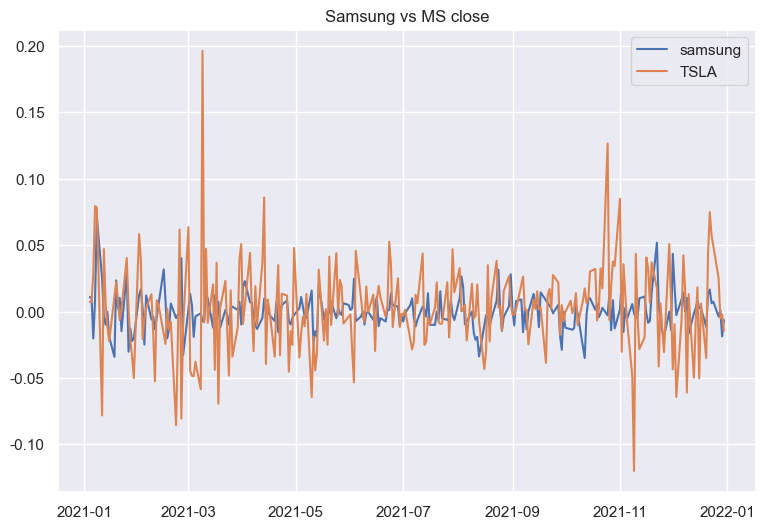

In [33]:
plt.figure(figsize=(9, 6))
# plt.subplot(2, 1, 1)
plt.title('Samsung vs MS close')
plt.plot(df_ss.index, df_ss['pct_chg2'], label='samsung')
plt.plot(df_ts.index, df_ts['pct_chg2'], label='TSLA')
plt.legend()

In [34]:
df_ts

,Open,High,Low,Close,Adj Close,Volume,pct_chg2
Date,,,,,,,
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600,0.007317
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600,0.007317
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000,0.028390
2021-01-07,259.209991,272.329987,258.399994,272.013336,272.013336,154496700,0.079447
2021-01-08,285.333344,294.829987,279.463318,293.339996,293.339996,225166500,0.078403
...,...,...,...,...,...,...,...
2021-12-23,335.600006,357.660004,332.519989,355.666656,355.666656,92713200,0.057619
2021-12-27,357.890015,372.333344,356.906677,364.646667,364.646667,71145900,0.025248
2021-12-28,369.829987,373.000000,359.473328,362.823334,362.823334,60324000,-0.005000


## 누적 수익률
- (1+r)*cumprod()-1

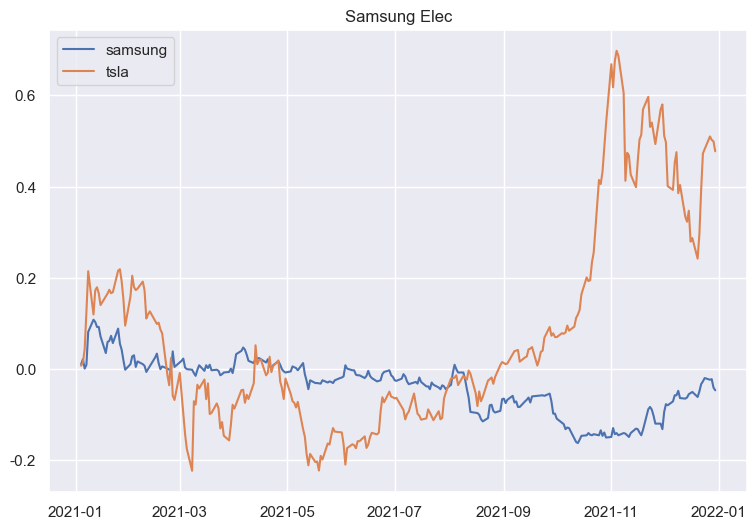

In [43]:
# 수익의 변화를 비교해 볼 수 있음 --> 테슬라가 삼성보다 큰 수익을 남김
plt.figure(figsize=(9, 6))
plt.title('Samsung Elec')
plt.plot(df_ss.index  ,((1+df_ss['pct_chg2']).cumprod())-1, label='samsung')  # cumprod : 누적 곱 
plt.plot(df_ts.index  ,((1+ df_ts['pct_chg2']).cumprod())-1, label='tsla')
plt.legend()

# [실습] 최대낙폭, 최대손실폭(Maximum DrowDown) : MDD 
* 특정 기간에서 발생한 최고점에서 최저점까지의 가장 큰 손실 == 최대 얼마의 손실이 날 수 있는가?
* (65-130)/130=-50%

<table>
<tr>
<td><img src='https://downloads.intercomcdn.com/i/o/79244225/7dad4f4f919e2be8a4a791e6/MDD.png?expires=1619851026&signature=aafb18bbd3ed5f6946ad53a5fb9f19d6dbc7316703c94667bc422babd38a2200'></td><br>
<td><img src='https://downloads.intercomcdn.com/i/o/79243103/d9a69bea18818ef2f126a6f8/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA+2018-10-04+15.48.43.png?expires=1619851026&signature=dcce134c2a4882b00790a53d5d8cba27350f8f48f8c59d681be007e99def032c'></td>
</tr>
</table>

## Data Load 

In [36]:
import FinanceDataReader as fdr
ohlcv_df   = fdr.DataReader('005930', '2021')  # 삼성전자(005930) , 2017-01-01 ~ Now
ohlcv_df.columns = [ str.lower() for str in ohlcv_df.columns]
print(ohlcv_df.shape)
ohlcv_df.head()

(575, 6)


,open,high,low,close,volume,change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170


## 1년 기준 최고가 

In [37]:
ohlcv_df['peak'] = ohlcv_df['close'].rolling(window=252, min_periods=1).max()  # 252(1년치 기준)일 간격으로 그룹화해 가격을 집계
ohlcv_df.head()

# 2021-01-04을 기준으로 252일 전까지를 그룹으로 묶었을 때의 최고가
# 2021-01-05을 기준으로 252일 전까지를 그룹으로 묶었을 때의 최고가.....

,open,high,low,close,volume,change,peak
Date,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691,83000.0
2021-01-05,81600,83900,81600,83900,35335669,0.010843,83900.0
2021-01-06,83300,84500,82100,82200,42089013,-0.020262,83900.0
2021-01-07,82800,84200,82700,82900,32644642,0.008516,83900.0
2021-01-08,83300,90000,83000,88800,59013307,0.071170,88800.0


## 최고가 대비 종가 비율

In [38]:
# 최고치 대비 현재 종가가 얼마나 하락했는가?
ohlcv_df['close_pick_rate'] =  (ohlcv_df['close'] - ohlcv_df['peak']) / ohlcv_df['peak']  #  diff / peak
ohlcv_df.head()

,open,high,low,close,volume,change,peak,close_pick_rate
Date,,,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691,83000.0,0.000000
2021-01-05,81600,83900,81600,83900,35335669,0.010843,83900.0,0.000000
2021-01-06,83300,84500,82100,82200,42089013,-0.020262,83900.0,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516,83900.0,-0.011919
2021-01-08,83300,90000,83000,88800,59013307,0.071170,88800.0,0.000000


## MDD
- ‘최대 낙폭’ 또는 ‘최대 손실폭’

In [39]:
mdd = ohlcv_df.rolling(window=252, min_periods=1)['close_pick_rate'].min()
mdd.min()

-0.34658385093167704

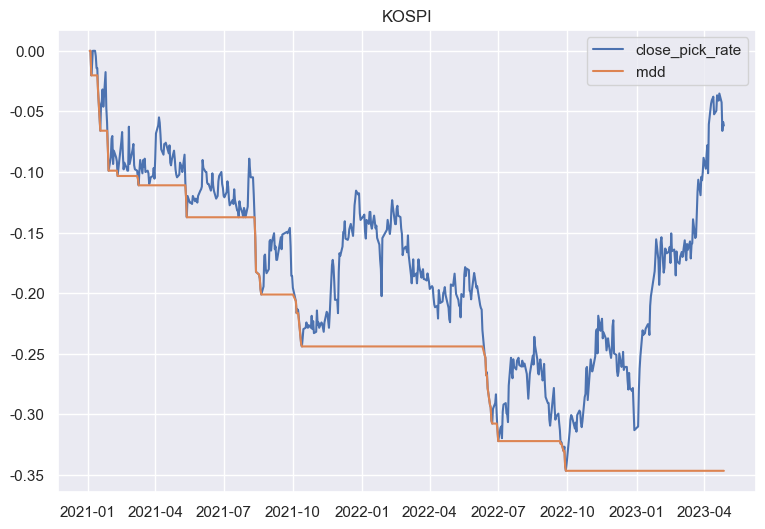

In [40]:
plt.figure(figsize=(9, 6))
plt.title('KOSPI')
plt.plot(ohlcv_df['close_pick_rate'], label='close_pick_rate')
plt.plot(mdd, label='mdd')
plt.legend()

### 공통함수 생성

* 차트 그리기

In [41]:
def myplot(df, nrows=5,  kind='line', title='제목', labels=False):  
    if nrows > 0:
        print(df.head(nrows))
    else:
        print(df.tail(nrows))
    
    if labels:
        cols = df.columns
        for i, col in enumerate(cols):
            df[col].plot(label=labels[i], kind=kind)
    else :
        df.plot(kind=kind)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [42]:
def myplotmix(df1, df2, y1='ylabel-1', y2='ylabel-2', kind1='bar', kind2='line', title='제목',  nrows1=5, nrows2=5,  labels=False):  
    ytl=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    if nrows1 > 0:
        print(df1.head(nrows1))
    elif nrows1 < 0:
        print(df1.tail(nrows1))
    if nrows2 > 0:
        print(df2.head(nrows2))
    else:
        print(df2.tail(nrows2))
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2=ax1.twinx()
    if kind1 == 'line':
        df1.plot(kind=kind1, ax=ax2, marker='d',color='#e35f62')  #color='y', 
        df2.plot(kind=kind2, ax=ax1)  #bar
    else:
        df1.plot(kind=kind1, ax=ax1,color='#bcbd22')
        df2.plot(kind=kind2, ax=ax2) #color='y',
        
    # df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    # ax1.set_xticklabels(df['date'])    
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel(y1) #, color='red')
    ax2.set_ylabel(y2) #, color='red')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.title(title)
    ax1.grid(False)
    ax2.grid(False)
    plt.show()

# 키움증권 수익률 계산 예시

* <b>투자원금평잔</b> = 평가 기간초 자산액계 + 기간내 총입출금고평잔
* <b>평가손익</b> = 기간말자산액 - 기간초자산액 + 출금 - 입금 + 총출고 - 총입고 + 매도 - 매수
* <b>수익률</b> = (평가손익/투자원금평잔) * 100

<img src='https://t1.daumcdn.net/cfile/tistory/99FF84455EB80BED05'>